# ASTR-19 Group Project
This notebook is for the astr-19 group project.

Authors: `Jack O'Brien`, `Leo Constantine`, `Veronica Sanchez M`, `Thomas Liao`


In [1]:
# In this cell, we include libraries
import astropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import multiprocessing # we brute-forced the curve fit lol
import math

Now, we're parsing the file. It will be returned as two lists containing data from each of the columns.

In [2]:
def ParseFile(_Filename:str = "dataset.txt"):
    
    # Firstly, read it into a list line by line
    Lines:list = []
    with open(_Filename, "r") as F:
        for Line in F:
            Lines.append(Line)
    
    # Now, remove those that start with a '#'
    FilteredLines:list = []
    for Line in Lines:
        if "#" not in Line:
            FilteredLines.append(Line)
            
    # Now parse into arrays
    Column0:list = []
    Column1:list = []
    Column2:list = []
    for Line in FilteredLines:
        Column0.append(Line[:3].replace(" ", ""))
        Column1.append(Line[4:9])
        Column2.append(Line[10:].strip("\n"))
            
    # Return arrays
    return Column0, Column1, Column2


Now, we are going to parse the times in terms of seconds, then sort it based on time.

In [3]:
def SortTimes(_Days:list, _Times:list, _Height:list):
    
    # Firstly, we enumerate times, and convert from hh:mm to seconds
    TimeSeconds:list = []
    for i in range(len(_Times)):
        Day = int(_Days[i]) - 1 # days start at 1, not 0
        Hours = int(_Times[i].split(":")[0])
        Minutes = int(_Times[i].split(":")[1])
        Seconds = (Day * 3600 * 24) + (Hours * 3600) + (Minutes * 60)
        TimeSeconds.append(Seconds)
        
    # Build Tuple For Sorting
    TimePairs:list = []
    for i in range(len(_Height)):
        CurrentTime_s = TimeSeconds[i]
        Height = _Height[i]
        TimePairs.append((CurrentTime_s, float(Height)))
    
    # Now Sort it
    TimePairs = sorted(TimePairs)
    
    # Now resplit it
    XValues = []
    YValues = []
    for Pair in TimePairs:
        XValues.append(Pair[0]/(3600))

        YValues.append(Pair[1])
    
    
    
    return XValues, YValues


In [4]:
def PlotTidalWave(_Timestamps:list, _Waveheights:list):
    plt.plot(_Timestamps, _Waveheights)
    plt.xlabel("Elapsed Time since start (hours)")
    plt.ylabel("Wave height (feet)")
    plt.title("Tidal Wave")

In [10]:
def Model(x, a, b, c, d, e, f, g):
    return (np.cos(a*x)*b + f) * (np.sin(c*x)*d + g) + e


In [11]:
def OptimizeModel(_XValues:list, _YValues:list, _Function:object):
    return scipy.optimize.curve_fit(_Function, _XValues, _YValues, p0=[0.017, 6, 0.221, 5, 1, 1, 1], maxfev=100000)


In [12]:
def PerformCurveFit(_XValues:list, _YValues:list):
    
    _XValues = np.asarray(_XValues)
    _YValues = np.asarray(_YValues)
    
    
    BestParams:list = []
    BestError:float = 9999999
    for b in range(1, 20):
        for d in range(1, 20):
    
            NumSamples:int = 500
            DetailedXValues:list = np.linspace(0, np.max(_XValues), NumSamples)
            DetailedYValues:list = np.interp(DetailedXValues, _XValues, _YValues)

            OptimizedParameters, ErrorValues = scipy.optimize.curve_fit(Model, DetailedXValues, DetailedYValues, p0=[0.017, b/3, 0.221, d/3, 1], maxfev=100000)

            ErrorArray = np.sqrt(np.diag(ErrorValues))
            AvgError = np.average(ErrorArray)

            if (AvgError < BestError):
                print(f"New Best Err: {AvgError}")
                BestError = AvgError
                BestParams = OptimizedParameters
    
    
    plt.plot(DetailedXValues, DetailedYValues)
    plt.plot(DetailedXValues, Model(DetailedXValues, *BestParams.tolist()))
    
    

In [15]:
def ThreadWorker(_ThreadNum:int, _Queue:object, _XValues:list, _YValues:list, _S:int, _E:int):
    
    
    NumSamples:int = 5000
    DetailedXValues:list = np.linspace(0, np.max(_XValues), NumSamples)
    DetailedYValues:list = np.interp(DetailedXValues, _XValues, _YValues)

    
    BestParams:list = []
    BestError:float = 9999999
    for b in range(1, 20):
        for d in range(1, 20):
            for a in range(_S, _E):
                for c in range (-5, 5):
    

                OptimizedParameters, ErrorValues = scipy.optimize.curve_fit(Model, DetailedXValues, DetailedYValues, p0=[a/10, b/3, c/5, d/3, 1, 1, 1], maxfev=100000)

                ErrorArray = np.abs(np.sqrt(np.diag(ErrorValues)))
                AvgError = np.average(ErrorArray)

                if (AvgError < BestError):
                    print(f"Thread {_ThreadNum} New Best Err: {AvgError}, Params: {OptimizedParameters}")
                    BestError = AvgError
                    BestParams = OptimizedParameters
        
    _Queue.put((BestParams.tolist(), BestError))



def PerformCurveFitThreaded(_XValues:list, _YValues:list, _NThreads=12):
    
    _XValues = np.asarray(_XValues)
    _YValues = np.asarray(_YValues)
    

    Queues:list = []
    ThreadPool:list = []
    for x in range(_NThreads):
        Queues.append(multiprocessing.Queue())
        ThreadPool.append(multiprocessing.Process(target=ThreadWorker, args=(x, Queues[x], _XValues, _YValues, x*2, (x+1)*2,)))
    
    for thread in ThreadPool:
        thread.start()
    
    
    list = []
    BestError:float = 9999999
    for x in range(len(ThreadPool)):
        thread = ThreadPool[x]
        thisQueue = Queues[x]
        
        Ret = thisQueue.get()
        thread.join()
        
        if (Ret[1] < BestError):
            BestError = Ret[1]
            BestParams = Ret[0]
    
    
    print(BestError)
    print(BestParams)
    
    NumSamples:int = 5000
    DetailedXValues:list = np.linspace(0, np.max(_XValues), NumSamples)
    DetailedYValues:list = np.interp(DetailedXValues, _XValues, _YValues)
    
    
    plt.plot(DetailedXValues, DetailedYValues)
    plt.plot(DetailedXValues, Model(DetailedXValues, *BestParams))
    
    

IndentationError: expected an indented block after 'for' statement on line 14 (2074420265.py, line 17)

Thread 0 New Best Err: 1033846.3222356484, Params: [-5.60572742e+01 -6.52615023e-03  2.24212731e-01  2.15020688e-01
 -2.20390797e-02  1.75714033e+00  1.62918601e+00]
Thread 1 New Best Err: 635487.3467289727, Params: [ 0.20320835  0.46100514  0.2243076   1.04671608  2.85186102  0.3592825
 -0.06401389]Thread 2 New Best Err: 556790.8622471055, Params: [ 0.39886671 -0.12443692  0.22423006  0.90368371  2.75284473  0.41921411
  0.2094685 ]

Thread 4 New Best Err: 698207.333407782, Params: [0.80358295 0.11689991 0.22424622 0.68601915 2.82411425 0.55065794
 0.03008439]Thread 5 New Best Err: 925018.4389013106, Params: [0.99936028 0.04099522 0.22422197 0.52747209 2.31174127 0.71639342
 0.73833839]

Thread 2 New Best Err: 524988.6031400642, Params: [ 0.3988659  -0.14230705  0.22423007  0.79017592  2.75286366  0.47943613
  0.18311823]
Thread 5 New Best Err: 496338.0290849683, Params: [ 1.10262454 -0.0259418   0.22421263  0.4816743   2.73661682  0.78448589
  0.13263842]
Thread 3 New Best Err: 52999

  9.91252899e+01  4.80032097e+00 -2.00579593e+01]

Thread 9 New Best Err: 231974.11417527564, Params: [ 1.80037746e+00  4.74056032e-03  2.24213172e-01  8.39056706e-02
  3.72081034e+01  4.50300142e+00 -7.63213550e+00]
Thread 6 New Best Err: 269953.73297150916, Params: [ 1.29536056e+00 -3.72935270e-03  2.24213279e-01  6.06692393e-02
  5.32111999e+01  6.22815001e+00 -8.08758572e+00]
Thread 4 New Best Err: 317444.41531927267, Params: [ 8.01187155e-01  2.68999591e-03  2.24213345e-01 -1.06521580e-01
  3.55694848e+01 -3.54730959e+00  9.22641830e+00]
Thread 9 New Best Err: 231350.4028442203, Params: [ 1.80037746e+00  4.43404368e-03  2.24213173e-01  9.05624918e-02
  3.68808610e+01  4.17200656e+00 -8.15920937e+00]
Thread 2 New Best Err: 116717.70046348659, Params: [ 5.02587987e-01  8.79074254e-03  2.24200896e-01  1.91217057e-02
  5.61601841e+02  1.97412385e+01 -2.83042284e+01]
Thread 0 New Best Err: 335341.411169021, Params: [ 1.10035202e-01  8.31344894e-03  2.15362730e-01  7.11643027e-02
  4.58

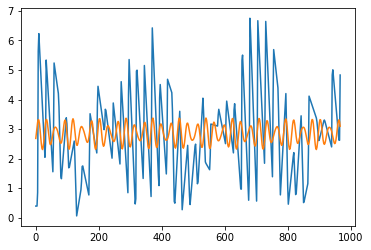

In [16]:
def Main():
    Days, TimesRaw, WaveHeights = ParseFile()
    Timestamps, WaveHeights = SortTimes(Days, TimesRaw, WaveHeights)

    # Make Initial Plot
    #PlotTidalWave(Timestamps, WaveHeights)
    
    PerformCurveFitThreaded(Timestamps, WaveHeights)
    
    
    


if __name__ == "__main__":
    Main()